# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Hidden Units)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [512] going forward for training due to time constraints, final evaluation can be batch size of 128/256 to achieve better utility scores
batch_sizes = [512]

# hidden_units default = [100, 200, 400, 200]
hidden_units = [
    [50, 100, 200, 100],
    [100, 200, 400, 200],
    [200, 400, 800, 400],
    [400, 800, 1600, 800]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2]
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp2_hidden_units_[[50, 100, 200, 100], [50, 100, 200, 100], [100, 200, 400, 200], [200, 400, 800, 400]]
model_params:  batch_size=512, hidden_unit=[50, 100, 200, 100], activation=<function relu at 0x7fab3a691950>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 8s 8ms/step - loss: 0.8269 - accuracy: 0.5032 - auc: 0.5043 - val_loss: 0.6976 - val_accuracy: 0.5233 - val_auc: 0.5310
Epoch 2/50
492/492 [==============================] - 3s 6ms/step - loss: 0.7525 - accuracy: 0.5029 - auc: 0.5047 - val_loss: 0.6928 - val_accuracy: 0.5255 - val_auc: 0.5356
Epoch 3/50
492/492 [==============================] - 3s 6ms/step - loss: 0.7317 - accuracy: 0.5080 - auc: 0.5111 - val_loss: 0.6907 - val_accuracy: 0.5304 - val_auc: 0.5438
Epoch 4/50
492/492 [==============================] - 3s 6ms/step - loss: 0.7188 - accuracy: 0.5114 - auc: 0.5162 - val_loss: 0.6889 - val_accuracy: 0.5327 - val

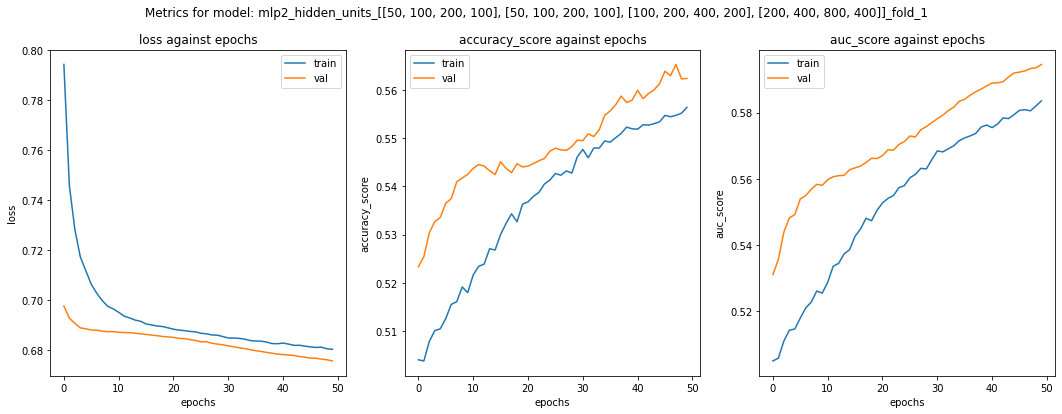

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.8410 - accuracy: 0.5034 - auc: 0.5048 - val_loss: 0.7020 - val_accuracy: 0.5150 - val_auc: 0.5215
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7603 - accuracy: 0.5048 - auc: 0.5074 - val_loss: 0.6957 - val_accuracy: 0.5200 - val_auc: 0.5276
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7377 - accuracy: 0.5082 - auc: 0.5114 - val_loss: 0.6930 - val_accuracy: 0.5242 - val_auc: 0.5339
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7259 - accuracy: 0.5073 - auc: 0.5111 - val_loss: 0.6908 - val_accuracy: 0.5303 - val_auc: 0.5416
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7177 - accuracy: 0.5110 - auc: 0.5138 - val_loss: 0.6901 - val_accuracy: 0.5319 - val_auc: 0.5431
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7113 - accuracy: 0.5129 - auc: 0

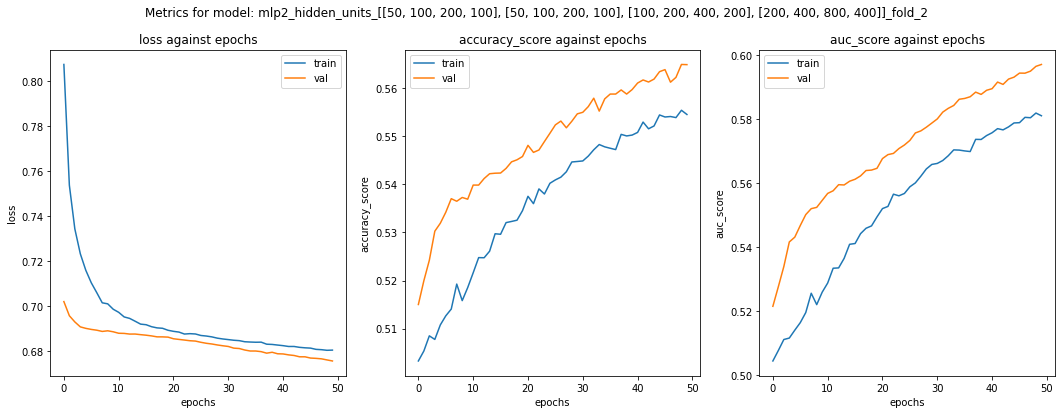

training model fold 3
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.8159 - accuracy: 0.5011 - auc: 0.5032 - val_loss: 0.6999 - val_accuracy: 0.5176 - val_auc: 0.5246
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7461 - accuracy: 0.5078 - auc: 0.5103 - val_loss: 0.6943 - val_accuracy: 0.5195 - val_auc: 0.5285
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7274 - accuracy: 0.5110 - auc: 0.5140 - val_loss: 0.6929 - val_accuracy: 0.5216 - val_auc: 0.5329
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7189 - accuracy: 0.5103 - auc: 0.5143 - val_loss: 0.6917 - val_accuracy: 0.5255 - val_auc: 0.5359
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7124 - accuracy: 0.5116 - auc: 0.5170 - val_loss: 0.6908 - val_accuracy: 0.5275 - val_auc: 0.5394
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7064 - accuracy: 0.5132 - auc: 0

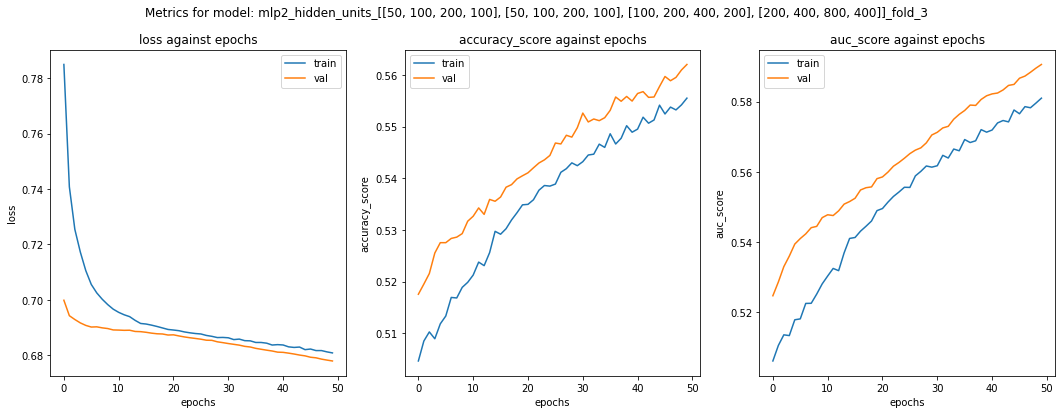

training model fold 4
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8274 - accuracy: 0.5042 - auc: 0.5061 - val_loss: 0.6991 - val_accuracy: 0.5194 - val_auc: 0.5275
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7568 - accuracy: 0.5061 - auc: 0.5082 - val_loss: 0.6935 - val_accuracy: 0.5263 - val_auc: 0.5369
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7351 - accuracy: 0.5079 - auc: 0.5116 - val_loss: 0.6912 - val_accuracy: 0.5305 - val_auc: 0.5409
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7239 - accuracy: 0.5086 - auc: 0.5112 - val_loss: 0.6898 - val_accuracy: 0.5309 - val_auc: 0.5461
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7153 - accuracy: 0.5095 - auc: 0.5127 - val_loss: 0.6890 - val_accuracy: 0.5351 - val_auc: 0.5513
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7078 - accuracy: 0.5138 - auc: 0

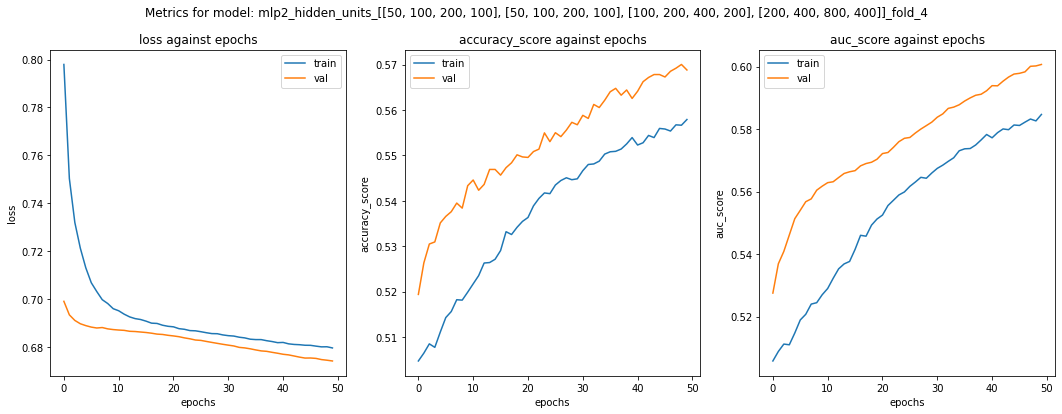

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8294 - accuracy: 0.5014 - auc: 0.5027 - val_loss: 0.7020 - val_accuracy: 0.5147 - val_auc: 0.5180
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7518 - accuracy: 0.5056 - auc: 0.5078 - val_loss: 0.6951 - val_accuracy: 0.5196 - val_auc: 0.5265
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7330 - accuracy: 0.5072 - auc: 0.5098 - val_loss: 0.6924 - val_accuracy: 0.5236 - val_auc: 0.5310
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7218 - accuracy: 0.5077 - auc: 0.5105 - val_loss: 0.6912 - val_accuracy: 0.5248 - val_auc: 0.5348
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7123 - accuracy: 0.5112 - auc: 0.5157 - val_loss: 0.6903 - val_accuracy: 0.5275 - val_auc: 0.5393
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7067 - accuracy: 0.5144 - auc: 0

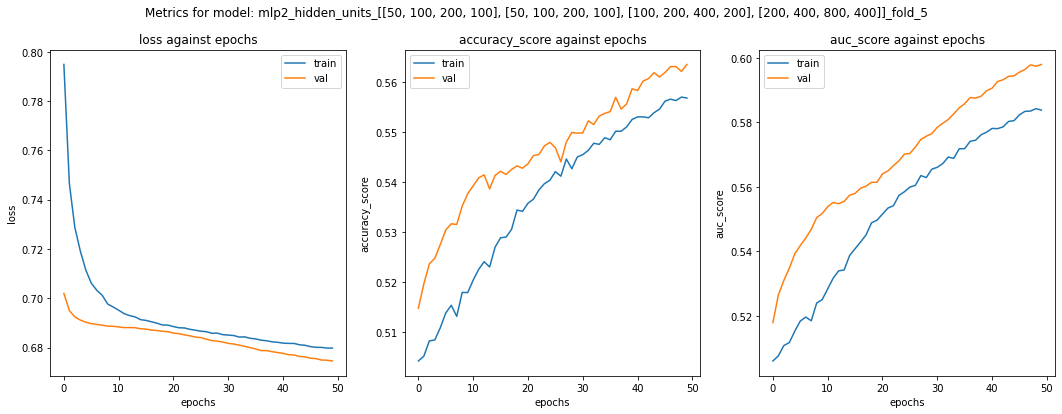

training model fold 6
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8150 - accuracy: 0.5006 - auc: 0.5016 - val_loss: 0.7006 - val_accuracy: 0.5137 - val_auc: 0.5181
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7497 - accuracy: 0.5064 - auc: 0.5083 - val_loss: 0.6949 - val_accuracy: 0.5180 - val_auc: 0.5256
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7314 - accuracy: 0.5062 - auc: 0.5086 - val_loss: 0.6924 - val_accuracy: 0.5192 - val_auc: 0.5301
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7212 - accuracy: 0.5091 - auc: 0.5116 - val_loss: 0.6906 - val_accuracy: 0.5249 - val_auc: 0.5365
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7117 - accuracy: 0.5134 - auc: 0.5172 - val_loss: 0.6901 - val_accuracy: 0.5275 - val_auc: 0.5399
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7075 - accuracy: 0.5140 - auc: 0

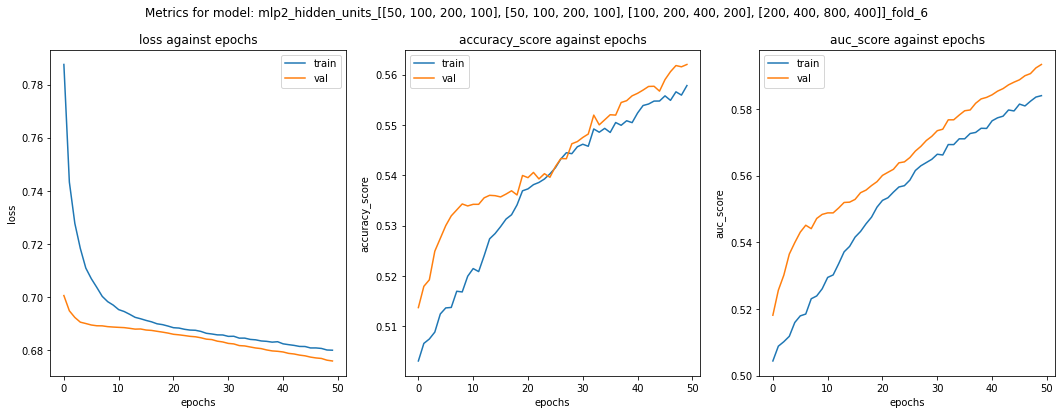

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8385 - accuracy: 0.5022 - auc: 0.5026 - val_loss: 0.7015 - val_accuracy: 0.5080 - val_auc: 0.5159
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7546 - accuracy: 0.5078 - auc: 0.5087 - val_loss: 0.6957 - val_accuracy: 0.5142 - val_auc: 0.5260
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7323 - accuracy: 0.5081 - auc: 0.5113 - val_loss: 0.6928 - val_accuracy: 0.5203 - val_auc: 0.5302
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7209 - accuracy: 0.5095 - auc: 0.5129 - val_loss: 0.6912 - val_accuracy: 0.5235 - val_auc: 0.5355
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7121 - accuracy: 0.5102 - auc: 0.5160 - val_loss: 0.6902 - val_accuracy: 0.5263 - val_auc: 0.5399
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7070 - accuracy: 0.5129 - auc: 0

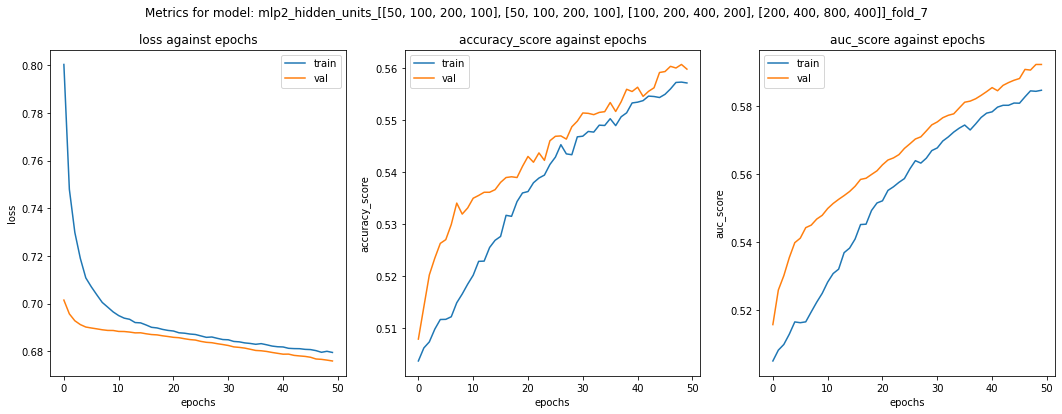

training model fold 8
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8218 - accuracy: 0.5023 - auc: 0.5042 - val_loss: 0.7007 - val_accuracy: 0.5135 - val_auc: 0.5201
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7492 - accuracy: 0.5047 - auc: 0.5063 - val_loss: 0.6952 - val_accuracy: 0.5181 - val_auc: 0.5260
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7283 - accuracy: 0.5076 - auc: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.5221 - val_auc: 0.5305
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7183 - accuracy: 0.5109 - auc: 0.5147 - val_loss: 0.6913 - val_accuracy: 0.5279 - val_auc: 0.5354
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7126 - accuracy: 0.5102 - auc: 0.5132 - val_loss: 0.6905 - val_accuracy: 0.5297 - val_auc: 0.5397
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7080 - accuracy: 0.5120 - auc: 0

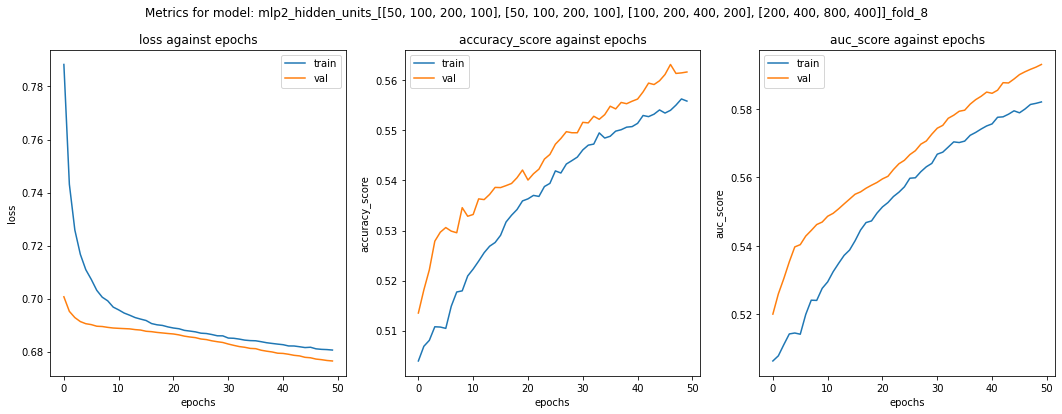

training model fold 9
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8167 - accuracy: 0.5031 - auc: 0.5025 - val_loss: 0.7002 - val_accuracy: 0.5142 - val_auc: 0.5206
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7478 - accuracy: 0.5078 - auc: 0.5107 - val_loss: 0.6947 - val_accuracy: 0.5223 - val_auc: 0.5285
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7291 - accuracy: 0.5088 - auc: 0.5117 - val_loss: 0.6924 - val_accuracy: 0.5251 - val_auc: 0.5353
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7186 - accuracy: 0.5102 - auc: 0.5140 - val_loss: 0.6912 - val_accuracy: 0.5249 - val_auc: 0.5375
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7121 - accuracy: 0.5108 - auc: 0.5158 - val_loss: 0.6906 - val_accuracy: 0.5264 - val_auc: 0.5416
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7069 - accuracy: 0.5128 - auc: 0

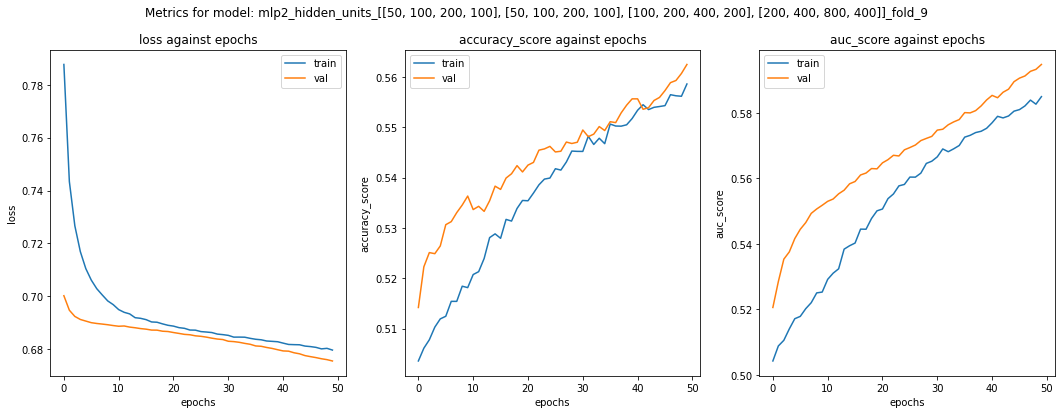

training model fold 10
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8196 - accuracy: 0.5038 - auc: 0.5044 - val_loss: 0.7006 - val_accuracy: 0.5162 - val_auc: 0.5195
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7461 - accuracy: 0.5084 - auc: 0.5108 - val_loss: 0.6951 - val_accuracy: 0.5191 - val_auc: 0.5277
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7302 - accuracy: 0.5091 - auc: 0.5102 - val_loss: 0.6920 - val_accuracy: 0.5229 - val_auc: 0.5343
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7203 - accuracy: 0.5077 - auc: 0.5113 - val_loss: 0.6909 - val_accuracy: 0.5275 - val_auc: 0.5395
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7116 - accuracy: 0.5103 - auc: 0.5145 - val_loss: 0.6903 - val_accuracy: 0.5297 - val_auc: 0.5435
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7068 - accuracy: 0.5139 - auc: 

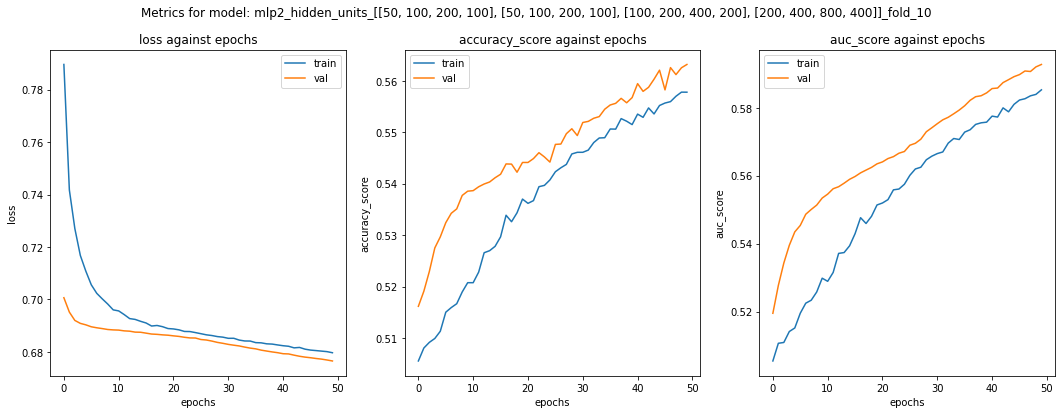

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [624.0863350247257, 0.5630918184180711, 0.5624637490526585, 8410.3, 7318.6, 6361.6, 5842.6]
saved model metrics

model_name:  mlp2_hidden_units_[[50, 100, 200, 100], [50, 100, 200, 100], [100, 200, 400, 200], [200, 400, 800, 400]]
model_params:  batch_size=512, hidden_unit=[50, 100, 200, 100], activation=<function relu at 0x7fab3a691950>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8441 - accuracy: 0.5018 - auc: 0.5022 - val_loss: 0.7002 - val_accuracy: 0.5175 - val_auc: 0.5231
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7599 - accuracy: 0.5056 - auc: 0.5069 - val_loss: 0.6943 - val_accuracy: 0.5209 - val_auc: 0.5318
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7375 - accuracy: 0.5088 - auc: 0.5115 - v

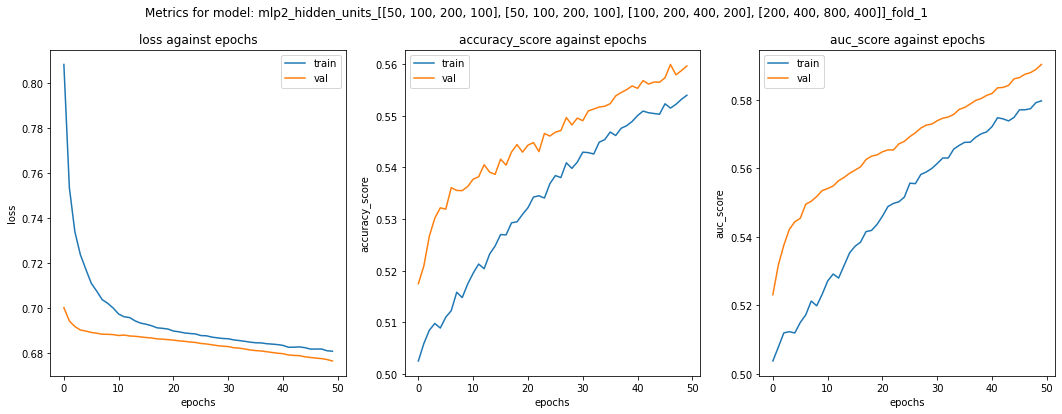

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8374 - accuracy: 0.5040 - auc: 0.5041 - val_loss: 0.7018 - val_accuracy: 0.5122 - val_auc: 0.5194
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7574 - accuracy: 0.5044 - auc: 0.5067 - val_loss: 0.6961 - val_accuracy: 0.5189 - val_auc: 0.5247
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7347 - accuracy: 0.5073 - auc: 0.5093 - val_loss: 0.6929 - val_accuracy: 0.5240 - val_auc: 0.5338
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7217 - accuracy: 0.5103 - auc: 0.5144 - val_loss: 0.6912 - val_accuracy: 0.5281 - val_auc: 0.5369
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7165 - accuracy: 0.5084 - auc: 0.5119 - val_loss: 0.6902 - val_accuracy: 0.5296 - val_auc: 0.5419
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7098 - accuracy: 0.5095 - auc: 0

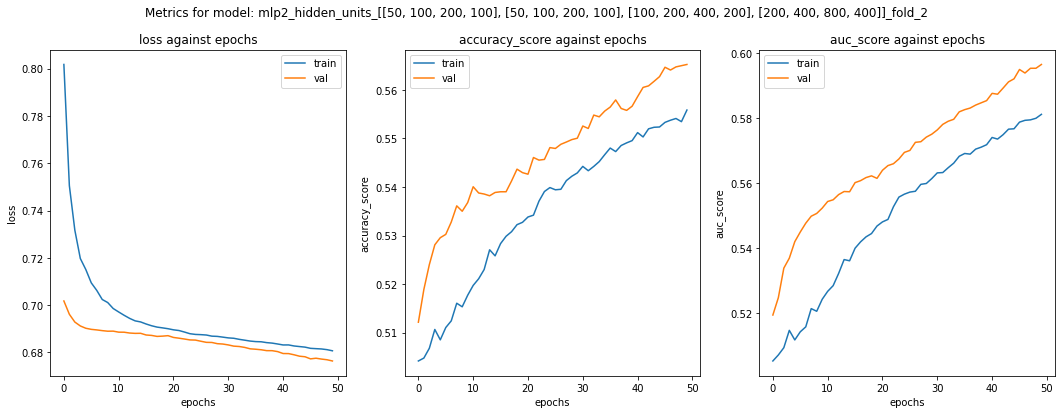

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8318 - accuracy: 0.5007 - auc: 0.5041 - val_loss: 0.7005 - val_accuracy: 0.5164 - val_auc: 0.5244
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7549 - accuracy: 0.5052 - auc: 0.5062 - val_loss: 0.6950 - val_accuracy: 0.5213 - val_auc: 0.5304
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7348 - accuracy: 0.5073 - auc: 0.5107 - val_loss: 0.6922 - val_accuracy: 0.5233 - val_auc: 0.5351
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7241 - accuracy: 0.5077 - auc: 0.5109 - val_loss: 0.6914 - val_accuracy: 0.5255 - val_auc: 0.5382
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7145 - accuracy: 0.5114 - auc: 0.5155 - val_loss: 0.6905 - val_accuracy: 0.5276 - val_auc: 0.5401
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7093 - accuracy: 0.5138 - auc: 0

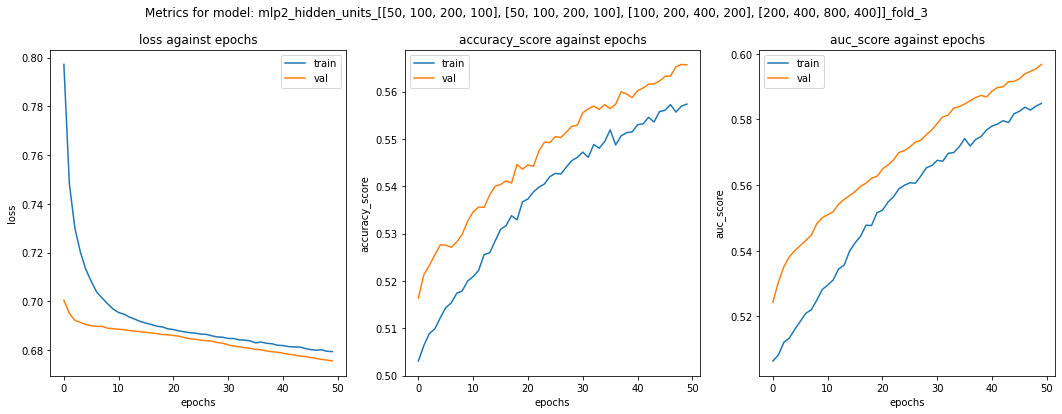

training model fold 4
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8309 - accuracy: 0.5031 - auc: 0.5029 - val_loss: 0.7010 - val_accuracy: 0.5151 - val_auc: 0.5215
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7538 - accuracy: 0.5031 - auc: 0.5049 - val_loss: 0.6945 - val_accuracy: 0.5192 - val_auc: 0.5324
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7327 - accuracy: 0.5067 - auc: 0.5091 - val_loss: 0.6917 - val_accuracy: 0.5239 - val_auc: 0.5375
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7204 - accuracy: 0.5103 - auc: 0.5131 - val_loss: 0.6901 - val_accuracy: 0.5267 - val_auc: 0.5421
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7125 - accuracy: 0.5116 - auc: 0.5164 - val_loss: 0.6892 - val_accuracy: 0.5321 - val_auc: 0.5463
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7090 - accuracy: 0.5129 - auc: 0

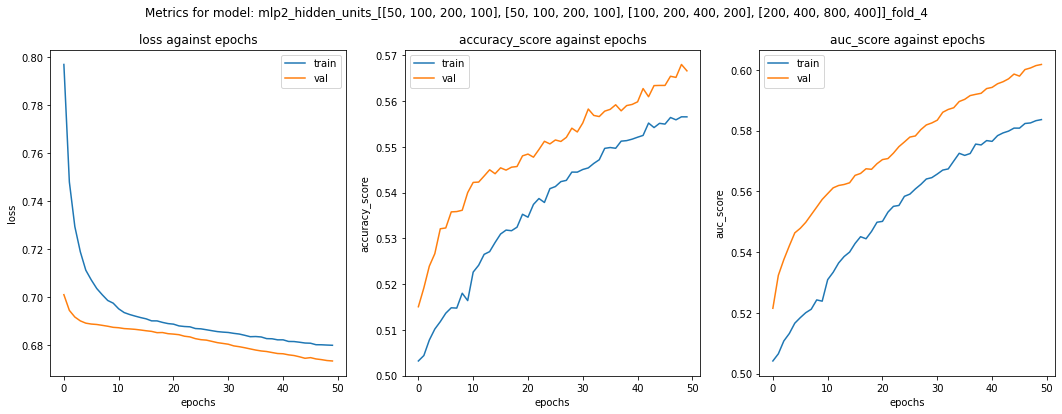

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8313 - accuracy: 0.5025 - auc: 0.5051 - val_loss: 0.7028 - val_accuracy: 0.5108 - val_auc: 0.5199
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7562 - accuracy: 0.5083 - auc: 0.5107 - val_loss: 0.6961 - val_accuracy: 0.5200 - val_auc: 0.5268
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7344 - accuracy: 0.5094 - auc: 0.5137 - val_loss: 0.6934 - val_accuracy: 0.5209 - val_auc: 0.5322
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7218 - accuracy: 0.5104 - auc: 0.5146 - val_loss: 0.6918 - val_accuracy: 0.5254 - val_auc: 0.5348
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7151 - accuracy: 0.5145 - auc: 0.5186 - val_loss: 0.6907 - val_accuracy: 0.5277 - val_auc: 0.5386
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7122 - accuracy: 0.5091 - auc: 0

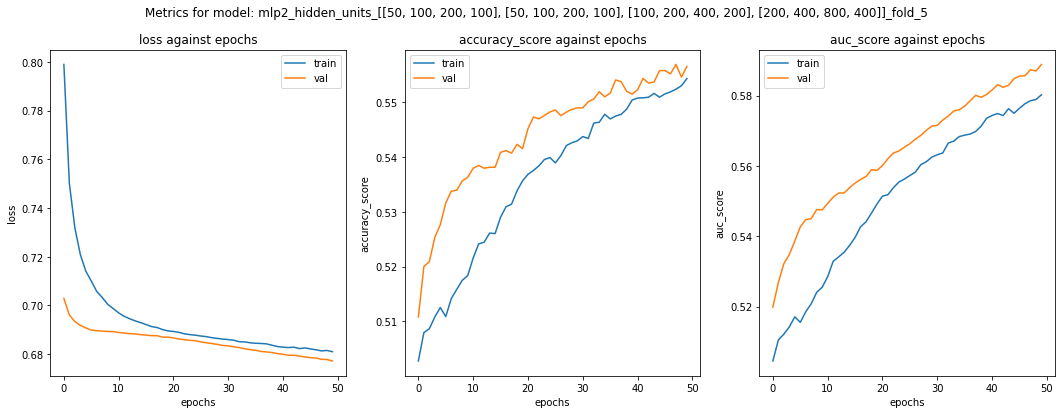

training model fold 6
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8152 - accuracy: 0.5023 - auc: 0.5041 - val_loss: 0.7009 - val_accuracy: 0.5086 - val_auc: 0.5182
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7452 - accuracy: 0.5048 - auc: 0.5076 - val_loss: 0.6955 - val_accuracy: 0.5154 - val_auc: 0.5255
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7284 - accuracy: 0.5069 - auc: 0.5083 - val_loss: 0.6935 - val_accuracy: 0.5185 - val_auc: 0.5289
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7179 - accuracy: 0.5085 - auc: 0.5122 - val_loss: 0.6921 - val_accuracy: 0.5234 - val_auc: 0.5329
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7114 - accuracy: 0.5111 - auc: 0.5150 - val_loss: 0.6912 - val_accuracy: 0.5238 - val_auc: 0.5357
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7061 - accuracy: 0.5124 - auc: 0

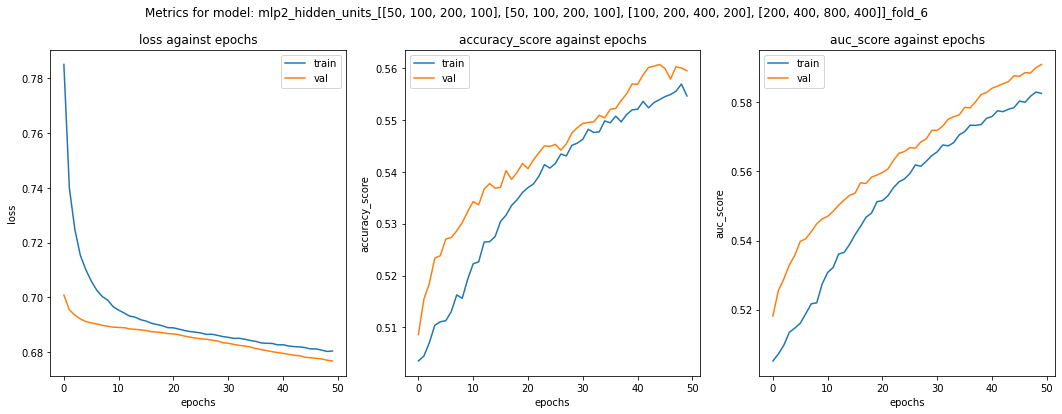

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8257 - accuracy: 0.5030 - auc: 0.5054 - val_loss: 0.7005 - val_accuracy: 0.5143 - val_auc: 0.5213
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7556 - accuracy: 0.5058 - auc: 0.5081 - val_loss: 0.6942 - val_accuracy: 0.5218 - val_auc: 0.5306
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7348 - accuracy: 0.5046 - auc: 0.5085 - val_loss: 0.6917 - val_accuracy: 0.5269 - val_auc: 0.5363
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7225 - accuracy: 0.5086 - auc: 0.5119 - val_loss: 0.6905 - val_accuracy: 0.5269 - val_auc: 0.5388
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7156 - accuracy: 0.5100 - auc: 0.5131 - val_loss: 0.6898 - val_accuracy: 0.5281 - val_auc: 0.5426
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7088 - accuracy: 0.5132 - auc: 0

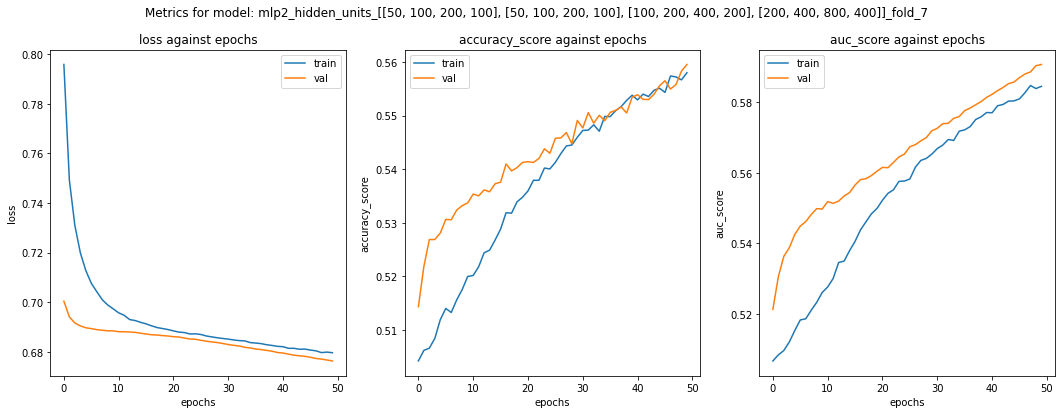

training model fold 8
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8305 - accuracy: 0.5060 - auc: 0.5079 - val_loss: 0.6999 - val_accuracy: 0.5146 - val_auc: 0.5236
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7535 - accuracy: 0.5076 - auc: 0.5099 - val_loss: 0.6943 - val_accuracy: 0.5171 - val_auc: 0.5298
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7324 - accuracy: 0.5100 - auc: 0.5133 - val_loss: 0.6914 - val_accuracy: 0.5234 - val_auc: 0.5369
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7219 - accuracy: 0.5112 - auc: 0.5134 - val_loss: 0.6902 - val_accuracy: 0.5265 - val_auc: 0.5415
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7150 - accuracy: 0.5115 - auc: 0.5160 - val_loss: 0.6897 - val_accuracy: 0.5302 - val_auc: 0.5434
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7085 - accuracy: 0.5134 - auc: 0

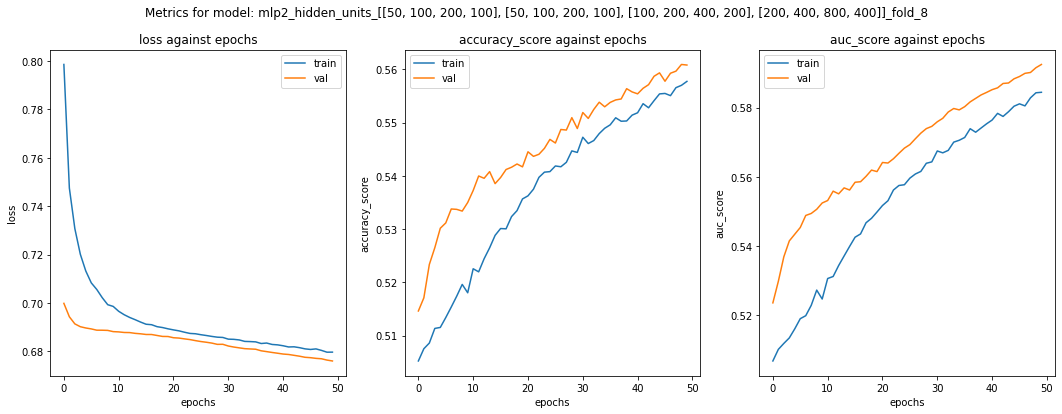

training model fold 9
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8153 - accuracy: 0.5028 - auc: 0.5040 - val_loss: 0.6980 - val_accuracy: 0.5216 - val_auc: 0.5307
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7490 - accuracy: 0.5062 - auc: 0.5090 - val_loss: 0.6930 - val_accuracy: 0.5262 - val_auc: 0.5390
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7289 - accuracy: 0.5089 - auc: 0.5124 - val_loss: 0.6911 - val_accuracy: 0.5298 - val_auc: 0.5450
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7196 - accuracy: 0.5076 - auc: 0.5104 - val_loss: 0.6894 - val_accuracy: 0.5340 - val_auc: 0.5495
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7114 - accuracy: 0.5124 - auc: 0.5161 - val_loss: 0.6891 - val_accuracy: 0.5353 - val_auc: 0.5516
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7052 - accuracy: 0.5165 - auc: 0

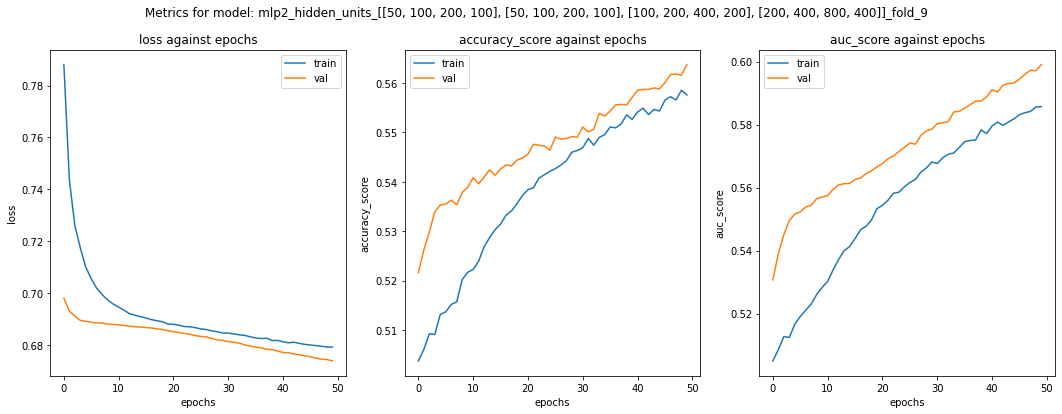

training model fold 10
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8167 - accuracy: 0.5037 - auc: 0.5050 - val_loss: 0.6994 - val_accuracy: 0.5143 - val_auc: 0.5204
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7476 - accuracy: 0.5028 - auc: 0.5054 - val_loss: 0.6939 - val_accuracy: 0.5197 - val_auc: 0.5292
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7304 - accuracy: 0.5059 - auc: 0.5082 - val_loss: 0.6917 - val_accuracy: 0.5249 - val_auc: 0.5352
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7188 - accuracy: 0.5112 - auc: 0.5135 - val_loss: 0.6907 - val_accuracy: 0.5259 - val_auc: 0.5395
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7108 - accuracy: 0.5093 - auc: 0.5145 - val_loss: 0.6903 - val_accuracy: 0.5248 - val_auc: 0.5410
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7057 - accuracy: 0.5133 - auc: 

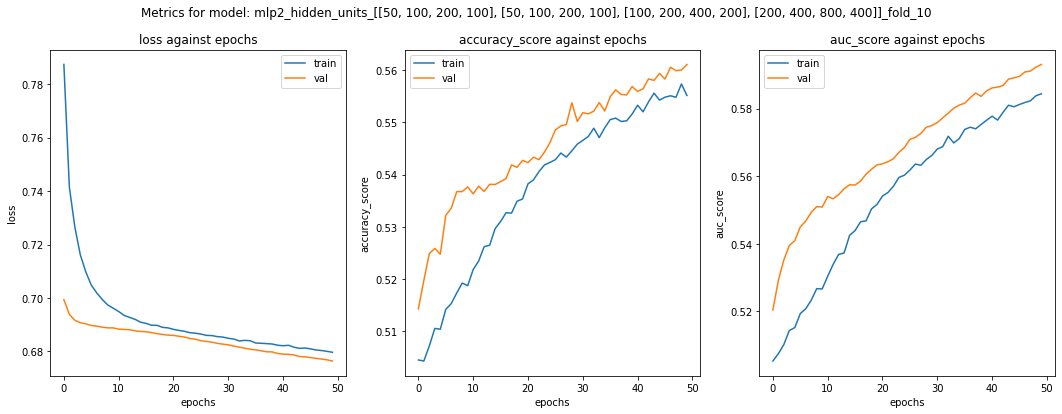

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [626.5271209947192, 0.5618424099073449, 0.5612029766643601, 8426.6, 7267.4, 6412.8, 5826.3]
saved model metrics

model_name:  mlp2_hidden_units_[[50, 100, 200, 100], [50, 100, 200, 100], [100, 200, 400, 200], [200, 400, 800, 400]]
model_params:  batch_size=512, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7fab3a691950>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8073 - accuracy: 0.5047 - auc: 0.5066 - val_loss: 0.6960 - val_accuracy: 0.5212 - val_auc: 0.5320
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7380 - accuracy: 0.5108 - auc: 0.5156 - val_loss: 0.6908 - val_accuracy: 0.5318 - val_auc: 0.5452
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7231 - accuracy: 0.5119 - auc: 0.5174 - 

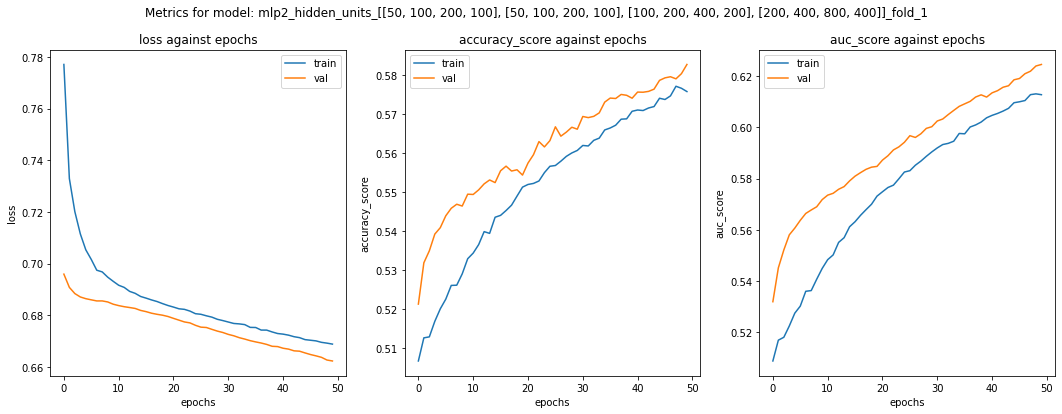

training model fold 2
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8121 - accuracy: 0.5041 - auc: 0.5053 - val_loss: 0.6990 - val_accuracy: 0.5224 - val_auc: 0.5312
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7414 - accuracy: 0.5109 - auc: 0.5155 - val_loss: 0.6927 - val_accuracy: 0.5312 - val_auc: 0.5437
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7244 - accuracy: 0.5137 - auc: 0.5206 - val_loss: 0.6909 - val_accuracy: 0.5336 - val_auc: 0.5483
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7144 - accuracy: 0.5177 - auc: 0.5237 - val_loss: 0.6885 - val_accuracy: 0.5372 - val_auc: 0.5547
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7086 - accuracy: 0.5185 - auc: 0.5249 - val_loss: 0.6875 - val_accuracy: 0.5407 - val_auc: 0.5574
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7035 - accuracy: 0.5226 - auc: 0

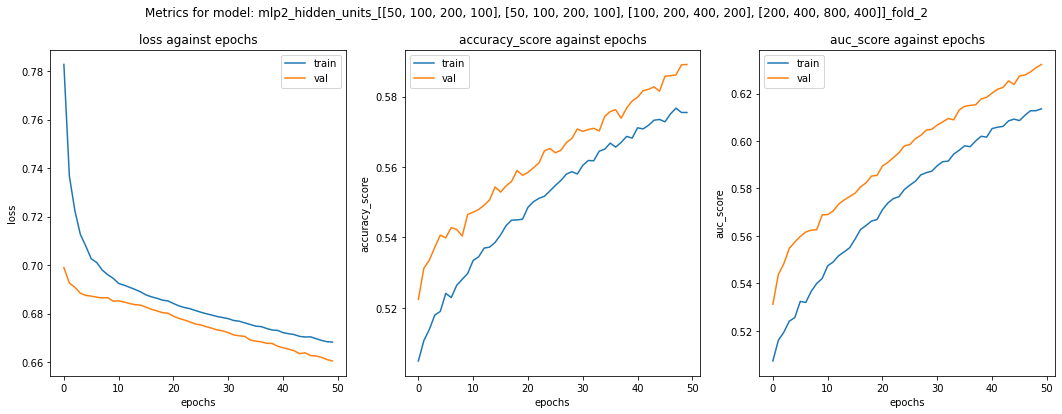

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8247 - accuracy: 0.5051 - auc: 0.5065 - val_loss: 0.6972 - val_accuracy: 0.5257 - val_auc: 0.5382
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7500 - accuracy: 0.5089 - auc: 0.5133 - val_loss: 0.6911 - val_accuracy: 0.5330 - val_auc: 0.5506
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7272 - accuracy: 0.5154 - auc: 0.5217 - val_loss: 0.6891 - val_accuracy: 0.5358 - val_auc: 0.5540
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7190 - accuracy: 0.5165 - auc: 0.5223 - val_loss: 0.6877 - val_accuracy: 0.5372 - val_auc: 0.5583
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7109 - accuracy: 0.5186 - auc: 0.5265 - val_loss: 0.6871 - val_accuracy: 0.5384 - val_auc: 0.5618
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7058 - accuracy: 0.5211 - auc: 0

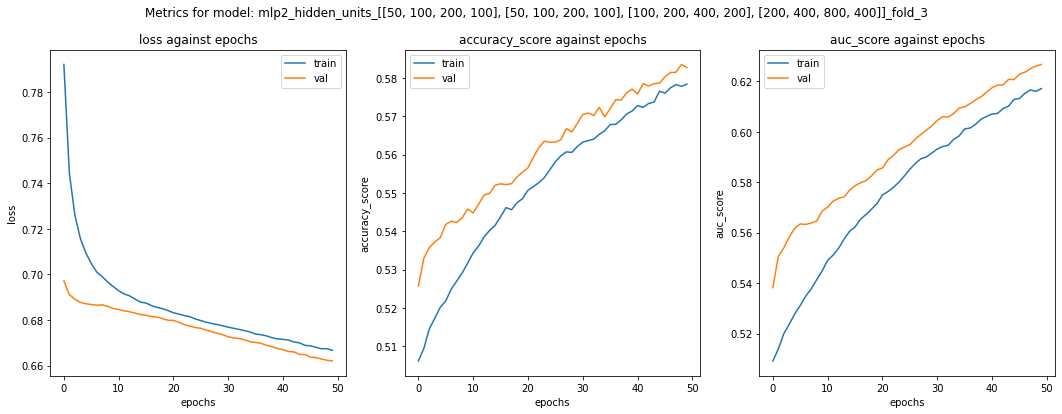

training model fold 4
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8099 - accuracy: 0.5054 - auc: 0.5081 - val_loss: 0.6960 - val_accuracy: 0.5222 - val_auc: 0.5335
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7448 - accuracy: 0.5082 - auc: 0.5127 - val_loss: 0.6906 - val_accuracy: 0.5290 - val_auc: 0.5467
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7256 - accuracy: 0.5135 - auc: 0.5189 - val_loss: 0.6889 - val_accuracy: 0.5354 - val_auc: 0.5531
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7157 - accuracy: 0.5142 - auc: 0.5220 - val_loss: 0.6875 - val_accuracy: 0.5411 - val_auc: 0.5578
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7105 - accuracy: 0.5188 - auc: 0.5259 - val_loss: 0.6872 - val_accuracy: 0.5390 - val_auc: 0.5607
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7059 - accuracy: 0.5177 - auc: 0

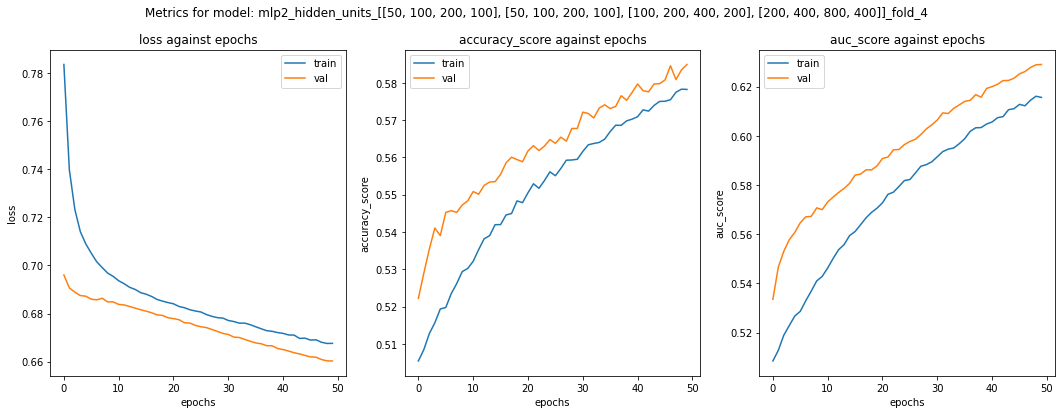

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8194 - accuracy: 0.5022 - auc: 0.5051 - val_loss: 0.6992 - val_accuracy: 0.5211 - val_auc: 0.5349
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7492 - accuracy: 0.5098 - auc: 0.5129 - val_loss: 0.6922 - val_accuracy: 0.5330 - val_auc: 0.5450
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7286 - accuracy: 0.5126 - auc: 0.5182 - val_loss: 0.6899 - val_accuracy: 0.5354 - val_auc: 0.5518
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7162 - accuracy: 0.5175 - auc: 0.5243 - val_loss: 0.6884 - val_accuracy: 0.5424 - val_auc: 0.5570
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7094 - accuracy: 0.5208 - auc: 0.5271 - val_loss: 0.6870 - val_accuracy: 0.5441 - val_auc: 0.5603
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7051 - accuracy: 0.5207 - auc: 0

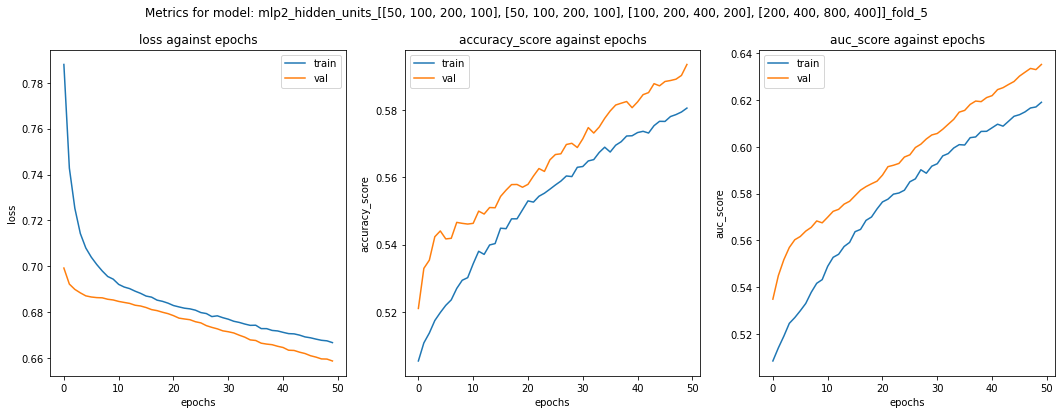

training model fold 6
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8141 - accuracy: 0.5025 - auc: 0.5038 - val_loss: 0.6976 - val_accuracy: 0.5188 - val_auc: 0.5301
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7399 - accuracy: 0.5144 - auc: 0.5184 - val_loss: 0.6924 - val_accuracy: 0.5340 - val_auc: 0.5438
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7237 - accuracy: 0.5173 - auc: 0.5219 - val_loss: 0.6921 - val_accuracy: 0.5331 - val_auc: 0.5456
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7156 - accuracy: 0.5160 - auc: 0.5253 - val_loss: 0.6884 - val_accuracy: 0.5370 - val_auc: 0.5526
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7089 - accuracy: 0.5192 - auc: 0.5275 - val_loss: 0.6879 - val_accuracy: 0.5353 - val_auc: 0.5547
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7047 - accuracy: 0.5201 - auc: 0

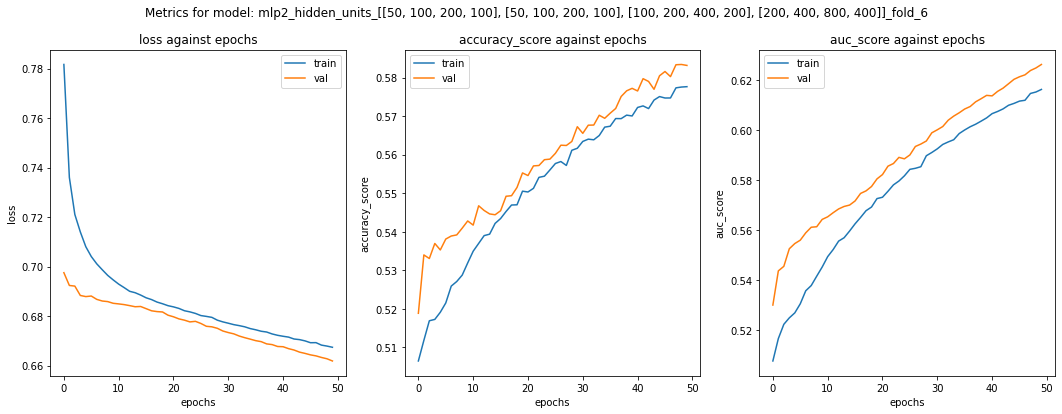

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8142 - accuracy: 0.5021 - auc: 0.5042 - val_loss: 0.6989 - val_accuracy: 0.5250 - val_auc: 0.5293
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7430 - accuracy: 0.5120 - auc: 0.5151 - val_loss: 0.6934 - val_accuracy: 0.5295 - val_auc: 0.5402
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7258 - accuracy: 0.5153 - auc: 0.5197 - val_loss: 0.6900 - val_accuracy: 0.5346 - val_auc: 0.5489
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7151 - accuracy: 0.5172 - auc: 0.5236 - val_loss: 0.6881 - val_accuracy: 0.5362 - val_auc: 0.5522
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7104 - accuracy: 0.5200 - auc: 0.5257 - val_loss: 0.6873 - val_accuracy: 0.5366 - val_auc: 0.5544
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7048 - accuracy: 0.5232 - auc: 0

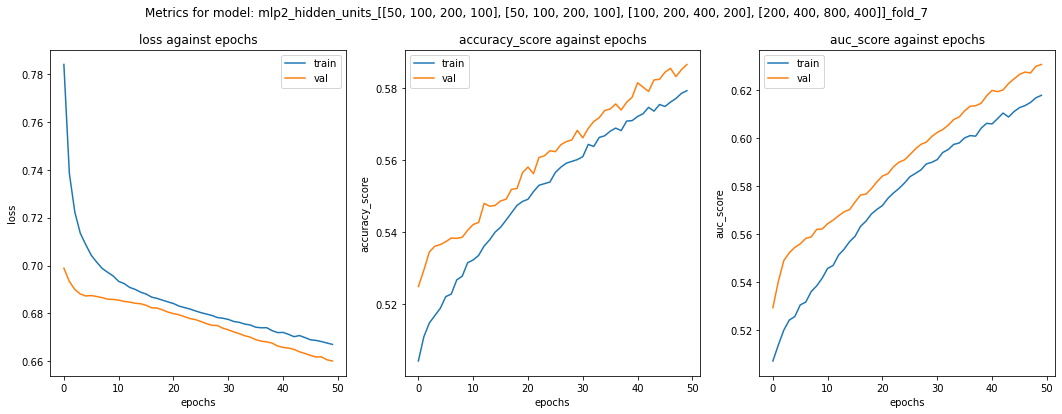

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8221 - accuracy: 0.5044 - auc: 0.5076 - val_loss: 0.7002 - val_accuracy: 0.5196 - val_auc: 0.5304
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7481 - accuracy: 0.5127 - auc: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5287 - val_auc: 0.5439
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7297 - accuracy: 0.5137 - auc: 0.5182 - val_loss: 0.6889 - val_accuracy: 0.5337 - val_auc: 0.5511
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7169 - accuracy: 0.5160 - auc: 0.5236 - val_loss: 0.6876 - val_accuracy: 0.5415 - val_auc: 0.5582
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7104 - accuracy: 0.5193 - auc: 0.5279 - val_loss: 0.6869 - val_accuracy: 0.5435 - val_auc: 0.5610
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7069 - accuracy: 0.5186 - auc: 0

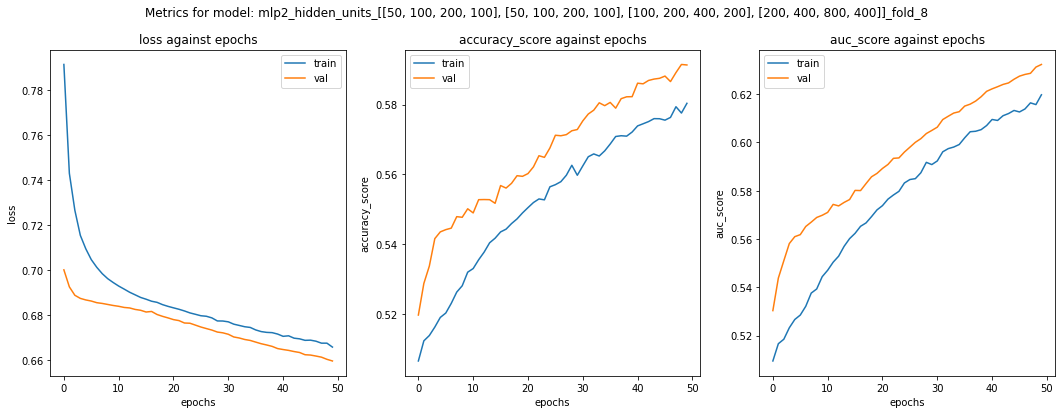

training model fold 9
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.8254 - accuracy: 0.5042 - auc: 0.5055 - val_loss: 0.6982 - val_accuracy: 0.5197 - val_auc: 0.5309
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7497 - accuracy: 0.5105 - auc: 0.5141 - val_loss: 0.6921 - val_accuracy: 0.5274 - val_auc: 0.5435
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7286 - accuracy: 0.5140 - auc: 0.5198 - val_loss: 0.6906 - val_accuracy: 0.5317 - val_auc: 0.5490
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7181 - accuracy: 0.5152 - auc: 0.5216 - val_loss: 0.6885 - val_accuracy: 0.5363 - val_auc: 0.5542
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7107 - accuracy: 0.5184 - auc: 0.5256 - val_loss: 0.6877 - val_accuracy: 0.5378 - val_auc: 0.5590
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7057 - accuracy: 0.5204 - auc: 

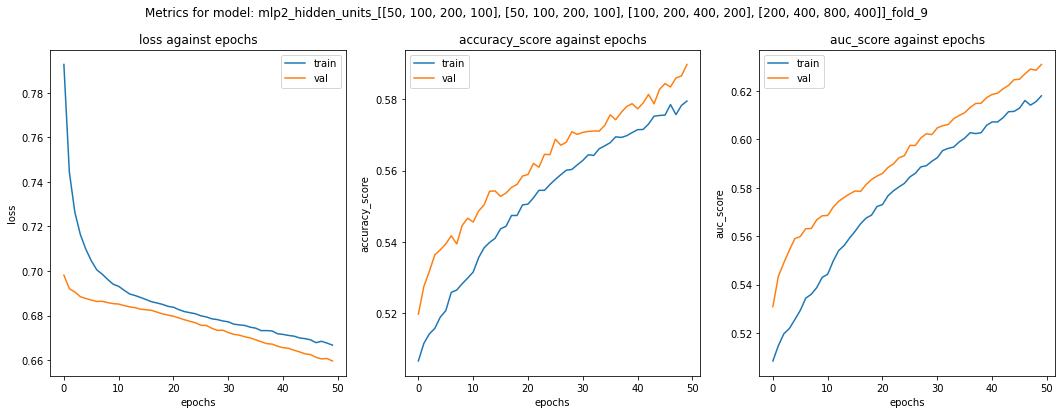

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 10ms/step - loss: 0.8212 - accuracy: 0.5044 - auc: 0.5058 - val_loss: 0.6991 - val_accuracy: 0.5284 - val_auc: 0.5371
Epoch 2/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7454 - accuracy: 0.5106 - auc: 0.5156 - val_loss: 0.6914 - val_accuracy: 0.5357 - val_auc: 0.5458
Epoch 3/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7277 - accuracy: 0.5120 - auc: 0.5164 - val_loss: 0.6892 - val_accuracy: 0.5369 - val_auc: 0.5513
Epoch 4/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7160 - accuracy: 0.5168 - auc: 0.5227 - val_loss: 0.6882 - val_accuracy: 0.5408 - val_auc: 0.5562
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7106 - accuracy: 0.5175 - auc: 0.5251 - val_loss: 0.6872 - val_accuracy: 0.5436 - val_auc: 0.5589
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7054 - accuracy: 0.5212 - auc:

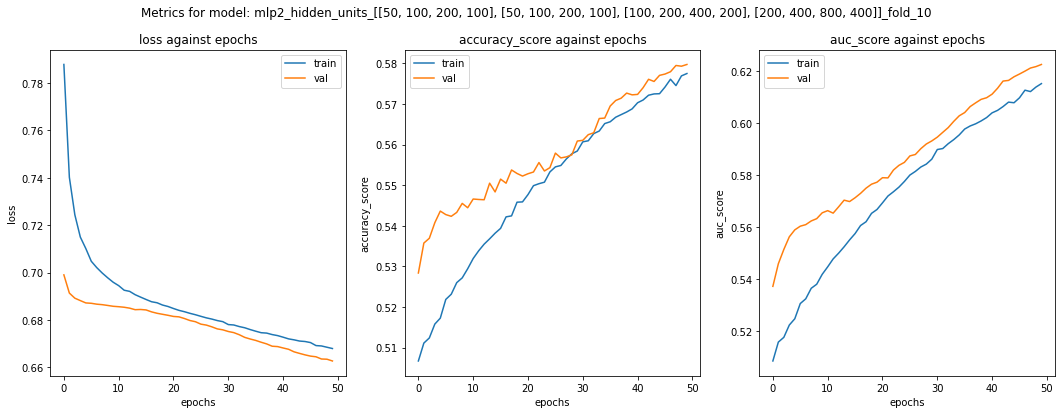

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [926.9308621883072, 0.5863652929126036, 0.5858199111248774, 8726.0, 7653.0, 6027.2, 5526.9]
saved model metrics

model_name:  mlp2_hidden_units_[[50, 100, 200, 100], [50, 100, 200, 100], [100, 200, 400, 200], [200, 400, 800, 400]]
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function relu at 0x7fab3a691950>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.8135 - accuracy: 0.5088 - auc: 0.5123 - val_loss: 0.6933 - val_accuracy: 0.5357 - val_auc: 0.5499
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7424 - accuracy: 0.5157 - auc: 0.5225 - val_loss: 0.6888 - val_accuracy: 0.5416 - val_auc: 0.5622
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7242 - accuracy: 0.5211 - auc: 0.5293

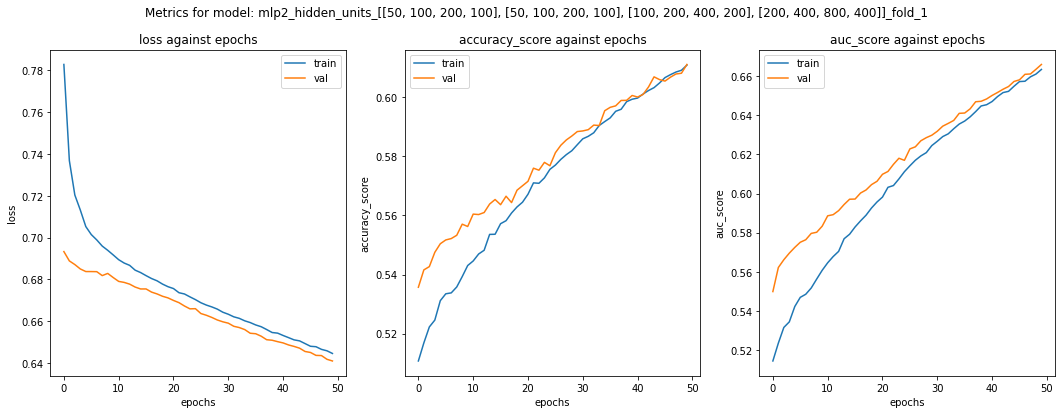

training model fold 2
Epoch 1/50
492/492 [==============================] - 7s 10ms/step - loss: 0.8032 - accuracy: 0.5085 - auc: 0.5110 - val_loss: 0.6911 - val_accuracy: 0.5404 - val_auc: 0.5590
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7392 - accuracy: 0.5148 - auc: 0.5219 - val_loss: 0.6869 - val_accuracy: 0.5457 - val_auc: 0.5677
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7207 - accuracy: 0.5211 - auc: 0.5293 - val_loss: 0.6851 - val_accuracy: 0.5521 - val_auc: 0.5743
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7094 - accuracy: 0.5276 - auc: 0.5390 - val_loss: 0.6834 - val_accuracy: 0.5549 - val_auc: 0.5793
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7054 - accuracy: 0.5291 - auc: 0.5396 - val_loss: 0.6816 - val_accuracy: 0.5566 - val_auc: 0.5831
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7006 - accuracy: 0.5329 - 

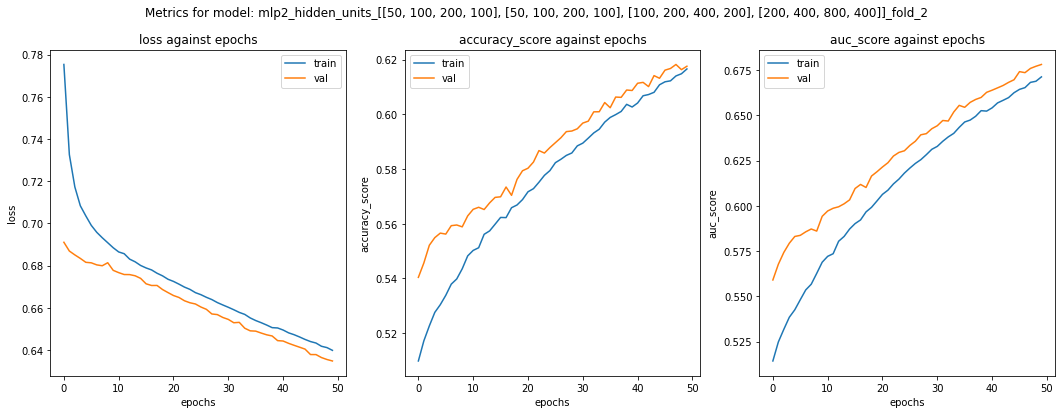

training model fold 3
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8189 - accuracy: 0.5074 - auc: 0.5109 - val_loss: 0.6976 - val_accuracy: 0.5301 - val_auc: 0.5437
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7432 - accuracy: 0.5152 - auc: 0.5232 - val_loss: 0.6899 - val_accuracy: 0.5413 - val_auc: 0.5583
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7236 - accuracy: 0.5223 - auc: 0.5303 - val_loss: 0.6884 - val_accuracy: 0.5413 - val_auc: 0.5630
Epoch 4/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7142 - accuracy: 0.5260 - auc: 0.5365 - val_loss: 0.6874 - val_accuracy: 0.5482 - val_auc: 0.5693
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7075 - accuracy: 0.5297 - auc: 0.5414 - val_loss: 0.6862 - val_accuracy: 0.5475 - val_auc: 0.5716
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7017 - accuracy: 0.5328 - 

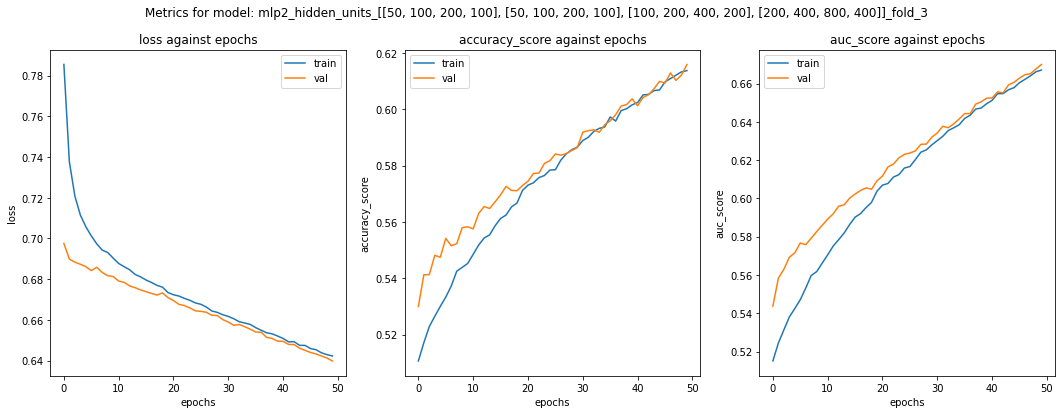

training model fold 4
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8159 - accuracy: 0.5072 - auc: 0.5099 - val_loss: 0.6990 - val_accuracy: 0.5296 - val_auc: 0.5460
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7441 - accuracy: 0.5146 - auc: 0.5209 - val_loss: 0.6856 - val_accuracy: 0.5510 - val_auc: 0.5713
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7251 - accuracy: 0.5214 - auc: 0.5296 - val_loss: 0.6846 - val_accuracy: 0.5534 - val_auc: 0.5754
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7138 - accuracy: 0.5265 - auc: 0.5367 - val_loss: 0.6857 - val_accuracy: 0.5531 - val_auc: 0.5764
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7076 - accuracy: 0.5284 - auc: 0.5407 - val_loss: 0.6832 - val_accuracy: 0.5528 - val_auc: 0.5772
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7034 - accuracy: 0.5307 - 

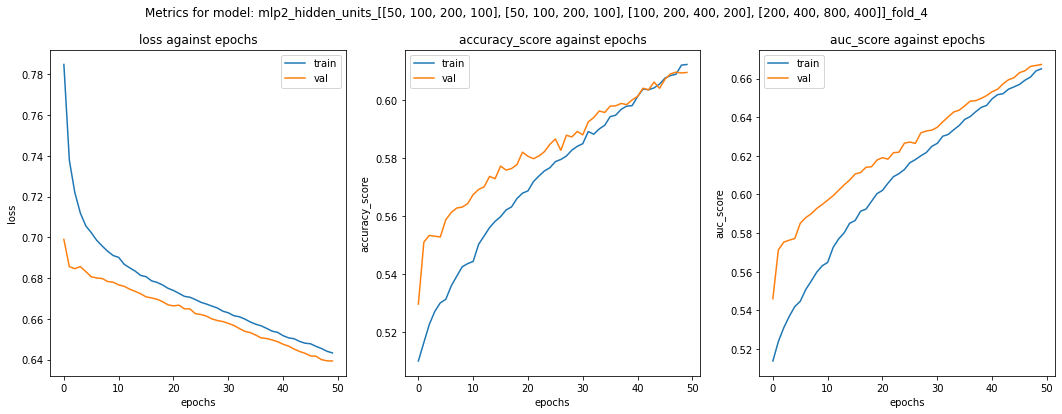

training model fold 5
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8199 - accuracy: 0.5092 - auc: 0.5126 - val_loss: 0.6965 - val_accuracy: 0.5307 - val_auc: 0.5448
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7454 - accuracy: 0.5155 - auc: 0.5229 - val_loss: 0.6899 - val_accuracy: 0.5392 - val_auc: 0.5564
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7250 - accuracy: 0.5230 - auc: 0.5309 - val_loss: 0.6870 - val_accuracy: 0.5463 - val_auc: 0.5648
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7142 - accuracy: 0.5268 - auc: 0.5373 - val_loss: 0.6850 - val_accuracy: 0.5467 - val_auc: 0.5702
Epoch 5/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7076 - accuracy: 0.5294 - auc: 0.5407 - val_loss: 0.6838 - val_accuracy: 0.5503 - val_auc: 0.5723
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7022 - accuracy: 0.5333 - 

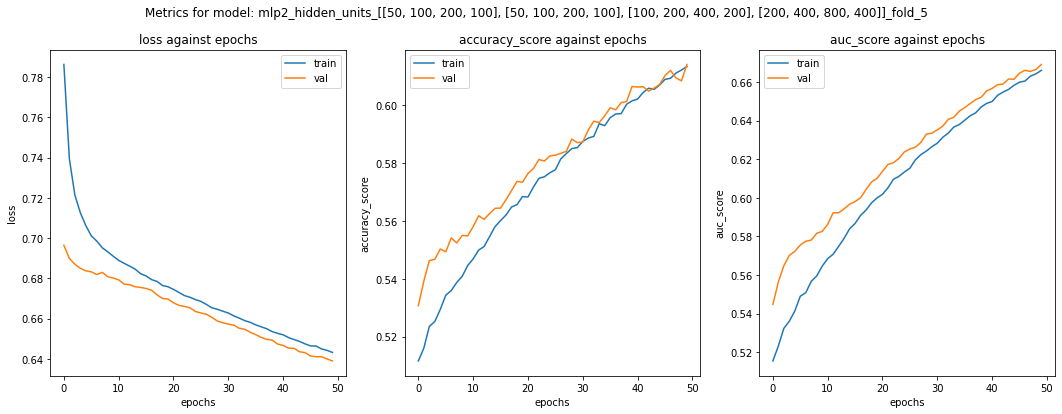

training model fold 6
Epoch 1/50
492/492 [==============================] - 7s 12ms/step - loss: 0.8231 - accuracy: 0.5068 - auc: 0.5102 - val_loss: 0.6971 - val_accuracy: 0.5332 - val_auc: 0.5451
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7458 - accuracy: 0.5159 - auc: 0.5231 - val_loss: 0.6893 - val_accuracy: 0.5405 - val_auc: 0.5601
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7243 - accuracy: 0.5222 - auc: 0.5311 - val_loss: 0.6893 - val_accuracy: 0.5465 - val_auc: 0.5637
Epoch 4/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7145 - accuracy: 0.5259 - auc: 0.5366 - val_loss: 0.6844 - val_accuracy: 0.5517 - val_auc: 0.5703
Epoch 5/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7061 - accuracy: 0.5308 - auc: 0.5436 - val_loss: 0.6834 - val_accuracy: 0.5519 - val_auc: 0.5734
Epoch 6/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7016 - accuracy: 0.5333 - 

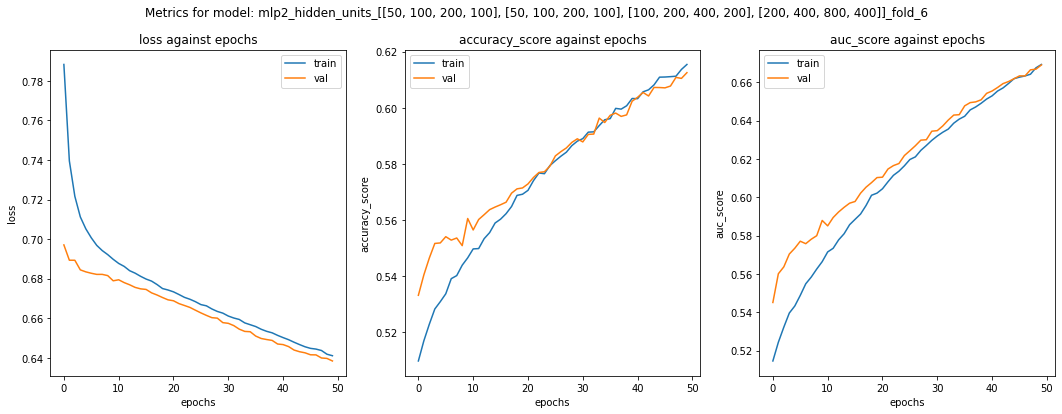

training model fold 7
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8111 - accuracy: 0.5087 - auc: 0.5110 - val_loss: 0.6931 - val_accuracy: 0.5372 - val_auc: 0.5517
Epoch 2/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7424 - accuracy: 0.5161 - auc: 0.5230 - val_loss: 0.6909 - val_accuracy: 0.5377 - val_auc: 0.5596
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7229 - accuracy: 0.5199 - auc: 0.5288 - val_loss: 0.6856 - val_accuracy: 0.5464 - val_auc: 0.5677
Epoch 4/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7133 - accuracy: 0.5241 - auc: 0.5332 - val_loss: 0.6848 - val_accuracy: 0.5464 - val_auc: 0.5693
Epoch 5/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7066 - accuracy: 0.5303 - auc: 0.5426 - val_loss: 0.6849 - val_accuracy: 0.5463 - val_auc: 0.5704
Epoch 6/50
492/492 [==============================] - 5s 10ms/step - loss: 0.7029 - accuracy: 0.5312 - 

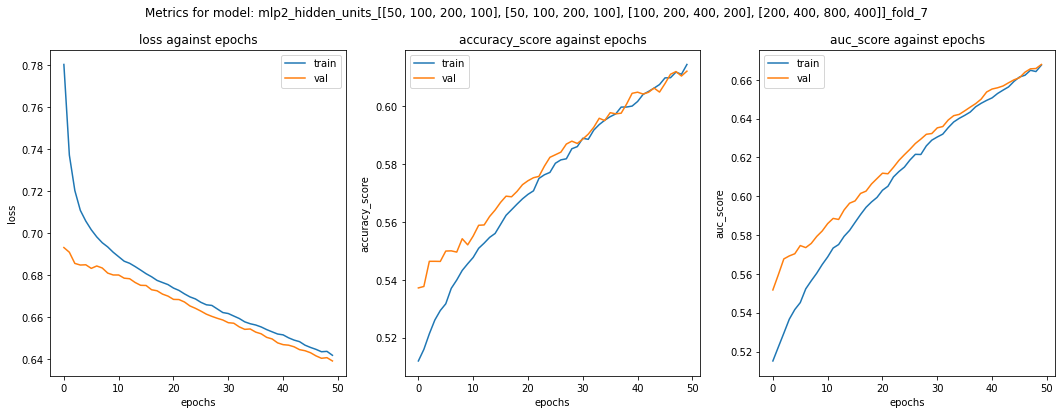

training model fold 8
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8137 - accuracy: 0.5072 - auc: 0.5103 - val_loss: 0.6925 - val_accuracy: 0.5349 - val_auc: 0.5514
Epoch 2/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7385 - accuracy: 0.5177 - auc: 0.5253 - val_loss: 0.6866 - val_accuracy: 0.5414 - val_auc: 0.5618
Epoch 3/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7225 - accuracy: 0.5207 - auc: 0.5289 - val_loss: 0.6844 - val_accuracy: 0.5462 - val_auc: 0.5689
Epoch 4/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7136 - accuracy: 0.5271 - auc: 0.5372 - val_loss: 0.6863 - val_accuracy: 0.5458 - val_auc: 0.5698
Epoch 5/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7055 - accuracy: 0.5307 - auc: 0.5442 - val_loss: 0.6829 - val_accuracy: 0.5506 - val_auc: 0.5760
Epoch 6/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7015 - accuracy: 0.5351 - 

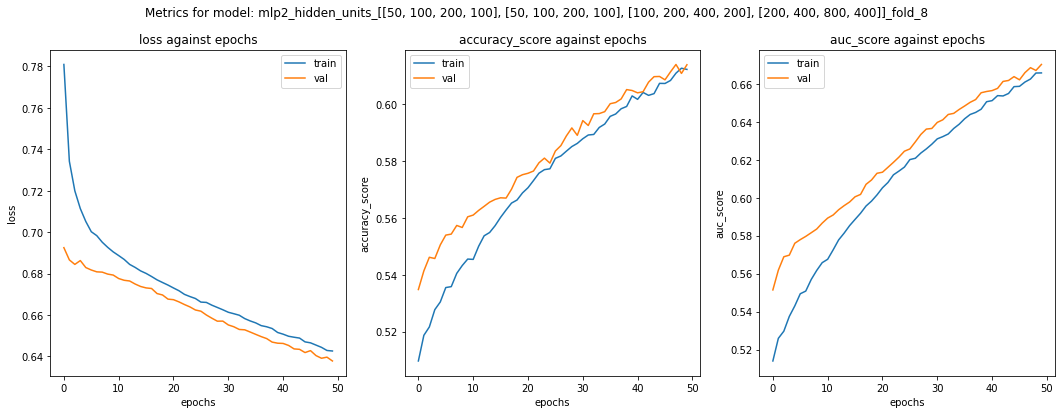

training model fold 9
Epoch 1/50
492/492 [==============================] - 7s 11ms/step - loss: 0.8077 - accuracy: 0.5069 - auc: 0.5091 - val_loss: 0.6940 - val_accuracy: 0.5343 - val_auc: 0.5514
Epoch 2/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7369 - accuracy: 0.5174 - auc: 0.5250 - val_loss: 0.6869 - val_accuracy: 0.5457 - val_auc: 0.5644
Epoch 3/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7205 - accuracy: 0.5207 - auc: 0.5291 - val_loss: 0.6868 - val_accuracy: 0.5473 - val_auc: 0.5658
Epoch 4/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7122 - accuracy: 0.5268 - auc: 0.5371 - val_loss: 0.6856 - val_accuracy: 0.5504 - val_auc: 0.5691
Epoch 5/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7059 - accuracy: 0.5293 - auc: 0.5410 - val_loss: 0.6855 - val_accuracy: 0.5490 - val_auc: 0.5702
Epoch 6/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7018 - accuracy: 0.5317 - 

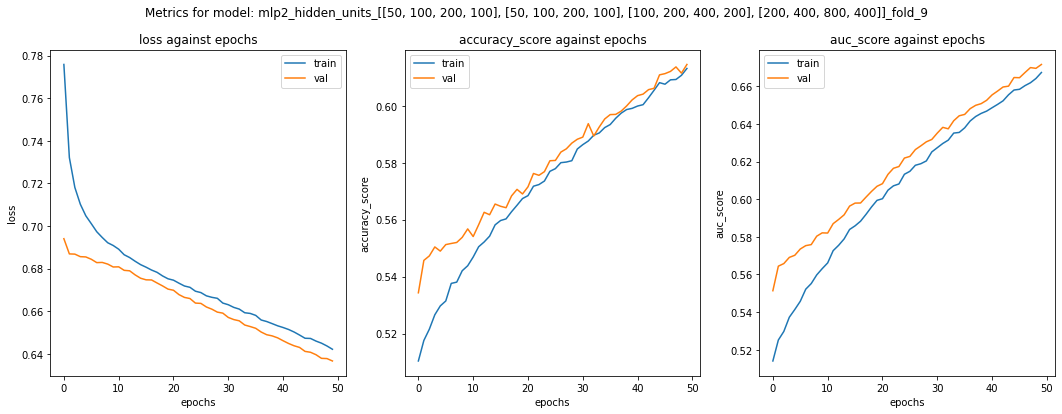

training model fold 10
Epoch 1/50
492/492 [==============================] - 7s 12ms/step - loss: 0.7993 - accuracy: 0.5061 - auc: 0.5094 - val_loss: 0.6946 - val_accuracy: 0.5336 - val_auc: 0.5462
Epoch 2/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7382 - accuracy: 0.5149 - auc: 0.5207 - val_loss: 0.6889 - val_accuracy: 0.5410 - val_auc: 0.5589
Epoch 3/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7194 - accuracy: 0.5225 - auc: 0.5313 - val_loss: 0.6868 - val_accuracy: 0.5455 - val_auc: 0.5645
Epoch 4/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7109 - accuracy: 0.5256 - auc: 0.5362 - val_loss: 0.6851 - val_accuracy: 0.5483 - val_auc: 0.5700
Epoch 5/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7060 - accuracy: 0.5269 - auc: 0.5390 - val_loss: 0.6838 - val_accuracy: 0.5521 - val_auc: 0.5749
Epoch 6/50
492/492 [==============================] - 5s 11ms/step - loss: 0.7005 - accuracy: 0.5348 -

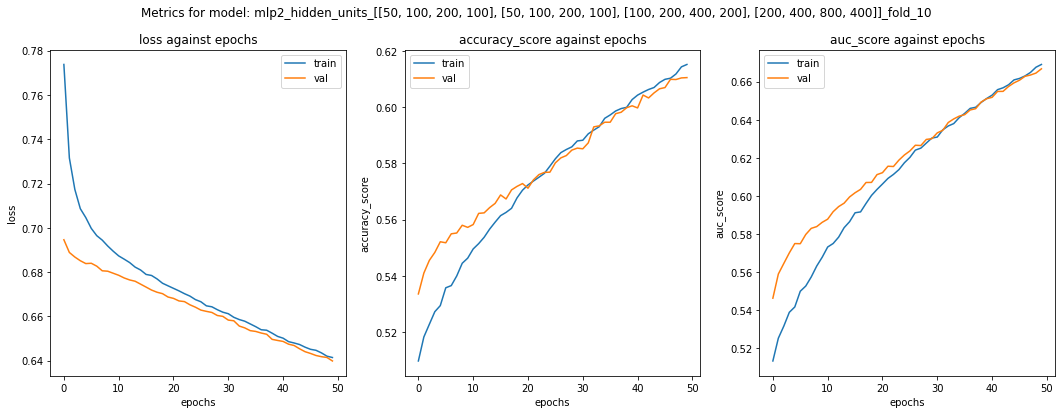

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1236.5527604418535, 0.6131829339939533, 0.6126348714970544, 9092.6, 8035.5, 5644.7, 5160.3]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12C_nndl_cv_mlp2_hidden_units"
            model_name = f"mlp2_hidden_units_{hidden_unit}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion

Best performing hyperparameters : hidden_units = [400, 800, 1600, 800]
* Utility score: 1575.825787
* Accuracy: 0.645062683

Increasing the number of hidden units increases the utility score, at the expense of training time. We are also unable to determine if the model has achieved convergence, therefore we cannot determine if overfitting has occured

We will be using hidden_units = [200, 400, 800, 400] going forward, but reverting to [400, 800, 1600, 800] for final testing

Consistent with 11C, but performs better



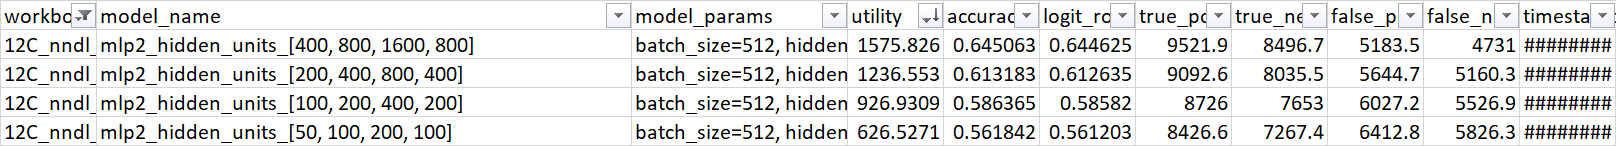